In [1]:
import numpy as np
import pandas as pd
import ipaddress
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import pyarrow
from ipaddress import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import tldextract
import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='white') 



/home/lab_services_student/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data=pd.read_csv('data_urls.csv')

data['url'] = data['url'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [3]:
data.drop_duplicates()
data.dropna()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0
...,...,...
822005,zzufg.com,0
822006,zzu.li,0
822007,zzz.co.uk,0
822008,zzzoolight.co.za,0


In [4]:
def rq(url):
    url=url.strip()
    url=url.strip('\'')
    url=url.strip('\"')
    url=url.strip('-')
    return str(url)

def url_num_num(url):
    return sum(c.isdigit() for c in url)

def url_num_dots(url):
    return url.count('.')
def url_num_slash(url):
    return url.count('/')
def url_num_per(url):
    return url.count('%')
def url_num_and(url):
    return url.count('&')


def domain(url):
    d=tldextract.extract(url)
    if d.domain == "":
        if d.subdomain:
            p=urlparse(d.subdomain)
            d=tldextract.extract(p.path)
            return d.domain
        return None
    return d.domain

def domain_l(dom):
    if dom:
        return len(dom)
    return 0

def dom_num_d(dom):
    if dom:
        return sum(c.isdigit() for c in dom)
    return 0

def subdomain(url):
    if re.match(r"https://",url):
        url=url.replace(r"https://","")
    if re.match(r"http://",url):
        url=url.replace(r"http://","")
    if re.match(r"www.",url):
        url = url.replace(r"www.","")
    if re.match(r'^[^a-zA-Z0-9]*www\.',url):
        url=url.replace(r'^[^a-zA-Z0-9]*www\.',"")
    
    d=tldextract.extract(url)
    
    if d.subdomain == "":
        url=d.subdomain
        d=tldextract.extract(url)
        if d.subdomain == "":
            return 0
        return 0 
    
    return d.subdomain

def top_domain(url):
    d=tldextract.extract(url)
    
    if d.suffix == "":
        return None
    return d.suffix

def is_ipAddress(url):
    try:
        ip_part = url.split(':')[0]
        ipaddress.ip_address(ip_part)
        ip = 1 #yes
    except:
        ip = 0 #no
    return ip
def lower(url):
    return url.lower()

def ptld(url):
    try:
        a=url.split('.')
        return len(a)
    except:
        return 0
def pcount(url):
    p=url.count('.')
    return p

def url_length(url):
    if url is not None:
        return len(url)
    else:
        return 0

def is_https(url):
    scheme = urlparse(url).scheme
    if scheme =='https':
         return 1 #yes
    else:
        return 0 #no
    
def num_sub(sub):
    if sub:
        sub=sub.split('.')
        return len(sub)
    return 0
    
def get_depth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth
def spl(url):
    a=url.split('.')
    return len(a)


In [5]:
data['url'] = data['url'].apply(rq)
data['url']=data['url'].apply(lower)
data['url_length'] = data['url'].apply(len)
data['class']=data['status'].apply(lambda x:  'phishing'if x==0 else 'legitimate')
data['num_special_chars'] = data['url'].apply(lambda x: sum([1 for char in x if char in ['@', '-', '?', '=','^','*','#','+','%','&','!']]))
data['num_digits']=data['url'].apply(url_num_num)
data['num_dots']= data['url'].apply(url_num_dots)
data['num_slash']= data['url'].apply(url_num_slash)
# data['num_and']= data['url'].apply(url_num_and)
# data['num_percent']= data['url'].apply(url_num_per)

data['domain']=data['url'].apply(domain)
data['domain_length']=data['domain'].apply(domain_l)
data['num_digits_in_domain'] = data['domain'].apply(dom_num_d)


data['subdomain']=data['url'].apply(subdomain)
# data['num_subdomains'] = data['subdomain'].apply(num_sub)

data['pcount']=data['url'].apply(pcount)


data['top_domain']=data['url'].apply(top_domain)
data['ptld']=data['top_domain'].apply(ptld)
data['spl']=data['url'].apply(spl)
data['is_IP']=data['url'].apply(is_ipAddress)
data['is_HTTPS']=data['url'].apply(is_https)
data['depth']=data['url'].apply(get_depth)

In [6]:
data.head()

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_IP,is_HTTPS,depth
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,7,2,0,godaddysites,12,0,0000111servicehelpdesk,2,com,1,3,0,0,1
1,000011accesswebform.godaddysites.com,0,36,phishing,0,6,2,0,godaddysites,12,0,000011accesswebform,2,com,1,3,0,0,1
2,00003.online,0,12,phishing,0,5,1,0,00003,5,5,0,1,online,1,2,0,0,1
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,4,2,0,godaddysites,12,0,0009servicedeskowa,2,com,1,3,0,0,1
4,000n38p.wcomhost.com,0,20,phishing,0,5,2,0,wcomhost,8,0,000n38p,2,com,1,3,0,0,1


## Cleaning

([<matplotlib.patches.Wedge at 0x7f1edf46baf0>,
 [Text(0.9613428287363138, 0.5346213292015783, 'HTTPS'),
  Text(-0.9668985206740376, -0.5245066736642707, 'Http'),
  Text(1.0999394671177516, -0.011539873340585071, 'IP Address')],
 [Text(0.524368815674353, 0.2916116341099518, '16.16%, 132797'),
  Text(-0.5273991930949296, -0.28609454927142036, '83.51%, 686468'),
  Text(0.599966982064228, -0.0062944763675918565, '0.33%, 2745')])

<Figure size 288x288 with 0 Axes>

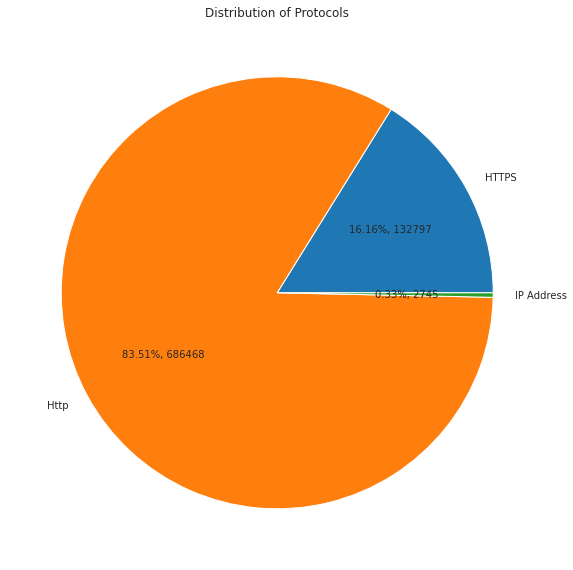

In [7]:
labels=["HTTPS","Http",'IP Address']
ht=data.is_HTTPS.sum()
ip=data.is_IP.sum()
h=data.loc[(data['is_HTTPS']==0)&(data['is_IP']==0)]
y=[ht,len(h),ip]
plt.figure(figsize=plt.figaspect(1))
fig = plt.figure(figsize=(15,30))
ax = fig.add_axes((0,0,.5,1))
ax.set_title('Distribution of Protocols')
plt.pie(y, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(y)/100 :.0f}') 


In [8]:
data=data[data['is_IP']==0]
data=data.drop('is_IP',axis=1)

In [9]:
data.isna().sum(axis=0)

url                        0
status                     0
url_length                 0
class                      0
num_special_chars          0
num_digits                 0
num_dots                   0
num_slash                  0
domain                    19
domain_length              0
num_digits_in_domain       0
subdomain                  0
pcount                     0
top_domain              5208
ptld                       0
spl                        0
is_HTTPS                   0
depth                      0
dtype: int64

In [10]:
data[data.domain.isna()]

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth
17080,ne.jp,0,5,phishing,0,0,1,0,None,0,0,0,1,ne.jp,2,2,0,1
55991,https:///forum.square-enix.com-i.cc/ffxiv/thre...,0,57,phishing,2,6,3,7,None,0,0,0,3,None,0,4,1,4
210262,/æõ\të0é «õíb pã5w~÷ü,1,23,legitimate,0,2,0,1,None,0,0,0,0,None,0,1,0,1
533769,gov.za/,1,7,legitimate,0,0,1,1,None,0,0,0,1,gov.za,2,2,0,1
541560,hr/wwwhr/business/electronic/companies/index.e...,1,52,legitimate,0,0,2,5,None,0,0,0,2,hr,1,3,0,6
653615,co.uk/movies/oscars/years/1942.htm,1,34,legitimate,0,4,2,4,None,0,0,0,2,co.uk,2,3,0,5
653616,co.uk/movies/oscars/years/1947.htm,1,34,legitimate,0,4,2,4,None,0,0,0,2,co.uk,2,3,0,5
653617,co.uk/movies/oscars/years/1952.htm,1,34,legitimate,0,4,2,4,None,0,0,0,2,co.uk,2,3,0,5
670137,?,0,1,phishing,1,0,0,0,None,0,0,0,0,None,0,1,0,0
680150,?guid=windows updates manager,0,29,phishing,2,0,0,0,None,0,0,0,0,None,0,1,0,0


In [11]:
data=data[data.pcount>0]

In [12]:
data.isna().sum(axis=0)

url                        0
status                     0
url_length                 0
class                      0
num_special_chars          0
num_digits                 0
num_dots                   0
num_slash                  0
domain                    10
domain_length              0
num_digits_in_domain       0
subdomain                  0
pcount                     0
top_domain              5113
ptld                       0
spl                        0
is_HTTPS                   0
depth                      0
dtype: int64

In [13]:
data=data[data.domain.notnull()]

In [14]:
data.duplicated().sum()

15827

In [15]:
data=data.drop_duplicates()

In [16]:
data.isna().sum(axis=0)

url                        0
status                     0
url_length                 0
class                      0
num_special_chars          0
num_digits                 0
num_dots                   0
num_slash                  0
domain                     0
domain_length              0
num_digits_in_domain       0
subdomain                  0
pcount                     0
top_domain              4864
ptld                       0
spl                        0
is_HTTPS                   0
depth                      0
dtype: int64

In [17]:
data.duplicated().sum()

0

In [18]:
data[(data.top_domain.isna())& data.domain.notnull()]

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth
28689,http://13.66.28.137/authflow/email-recovery,0,43,phishing,1,9,3,4,13.66.28.137,12,9,0,3,None,0,4,0,2
28734,http://221.150.115.216/wordpress/wp-content/ph...,0,81,phishing,1,30,3,7,221.150.115.216,15,12,0,3,None,0,4,0,4
28783,http://34.88.141.84/qhagd7do8tp5sdfsdfds4pbnzl...,0,55,phishing,0,17,3,4,34.88.141.84,12,9,0,3,None,0,4,0,1
28848,http://107.172.43.154/public/banks/tangerine/,0,45,phishing,0,11,3,6,107.172.43.154,14,11,0,3,None,0,4,0,3
29112,http://164.160.128.101/~asiagad1/dbs/,0,37,phishing,0,13,3,5,164.160.128.101,15,12,0,3,None,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749503,http://80.172.227.16/%7eclinica/nww.php?re-val...,0,92,phishing,7,24,5,4,80.172.227.16,13,10,0,5,None,0,6,0,2
749589,http://5.189.141.68/p/o/s/t/e/foo-autenticazio...,0,52,phishing,1,9,4,8,5.189.141.68,12,9,0,4,None,0,5,0,6
749770,http://158.69.157.36/zipa/cef/paginas/home-cai...,0,54,phishing,1,10,4,7,158.69.157.36,13,10,0,4,None,0,5,0,4
749823,http://213.136.77.91/p/o/s/t/e/foo-autenticazi...,0,53,phishing,1,10,4,8,213.136.77.91,13,10,0,4,None,0,5,0,6


In [19]:
data['dip']=data['domain'].apply(is_ipAddress)

In [20]:
data[(data.top_domain.isna())& (data.dip==0)]

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth,dip
149791,https://cfg.ssmt.ddoccomo.ne.jp.aswtenm,0,39,phishing,0,0,5,2,aswtenm,7,0,cfg.ssmt.ddoccomo.ne.jp,5,None,0,6,1,0,0
158977,https://8r1ho.veles-/,0,21,phishing,1,2,1,3,veles-,6,0,8r1ho,1,None,0,2,1,0,0
192092,www.udc.an/wp-includes/js/tinymce/themes/advan...,0,62,phishing,1,0,3,7,an,2,0,udc,3,None,0,4,0,8,0
192466,www.udc.an/wp-includes/js/tinymce/themes/advan...,0,60,phishing,1,0,3,7,an,2,0,udc,3,None,0,4,0,8,0
192591,772050312/www1.royalbank.com/cgi-bin/rbaccess/...,0,55,phishing,1,10,2,5,772050312,9,9,0,2,None,0,3,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681857,mozilla/4.0,0,11,phishing,0,2,1,1,mozilla,7,0,0,1,None,0,2,0,2,0
682873,localhost:82/tcp.exe,0,20,phishing,0,2,1,1,localhost,9,0,0,1,None,0,2,0,2,0
685428,tradesmartcoin.xz/k7w8qhi,0,25,phishing,0,2,1,1,xz,2,0,tradesmartcoin,1,None,0,2,0,2,0
685787,gycuni.top\sgbfaimi9ded2fkcff0prmorlmemo-rffra...,0,128,phishing,8,16,1,0,top\sgbfaimi9ded2fkcff0prmorlmemo-rffrasimkps-...,121,16,gycuni,1,None,0,2,0,1,0


In [21]:
data=data[(data.top_domain.notnull())]
data=data.drop(columns='dip')

In [22]:
data.isna().sum(axis=0)

url                     0
status                  0
url_length              0
class                   0
num_special_chars       0
num_digits              0
num_dots                0
num_slash               0
domain                  0
domain_length           0
num_digits_in_domain    0
subdomain               0
pcount                  0
top_domain              0
ptld                    0
spl                     0
is_HTTPS                0
depth                   0
dtype: int64

In [23]:
data[(data.subdomain.isna())]

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth


In [24]:
data[(data.subdomain.isna())&(data.spl!=data.ptld+1)]

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth


In [25]:
print(data.subdomain.notnull().sum())

798463


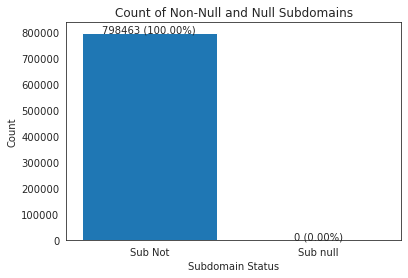

In [26]:
nnc = data['subdomain'].notnull().sum()
nc = data['subdomain'].isna().sum()
tc = len(data)
y = [nnc, nc]
percentages = [(count / tc) * 100 for count in y]
x=['Sub Not','Sub null']
plt.bar(x, y)
plt.xlabel('Subdomain Status')
plt.ylabel('Count')
plt.title('Count of Non-Null and Null Subdomains')
for i in range(len(y)):
    plt.text(x[i], y[i] + 0.5, f'{y[i]} ({percentages[i]:.2f}%)', ha='center')

In [27]:
m=data[data['status']==0].subdomain.value_counts() 
print(m[m.values>1])

0                                                                                                                                                                                            205739
9d345009-a-62cb3a1a-s-sites                                                                                                                                                                    1527
mail                                                                                                                                                                                           1210
amazon.co.jp                                                                                                                                                                                    673
s                                                                                                                                                                                               654
                    

In [28]:
data[data.subdomain=='s']

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth
22143,s.eaobd.co,0,10,phishing,0,0,2,0,eaobd,5,0,s,2,co,1,3,0,1
23971,s.oance.co,0,10,phishing,0,0,2,0,oance,5,0,s,2,co,1,3,0,1
24107,s.onous.co,0,10,phishing,0,0,2,0,onous,5,0,s,2,co,1,3,0,1
24138,s.ousic.co,0,10,phishing,0,0,2,0,ousic,5,0,s,2,co,1,3,0,1
29143,http://s.alchemer.com/s3/cza,0,28,phishing,0,1,2,4,alchemer,8,0,s,2,com,1,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810130,s.pzu.today,0,11,phishing,0,0,2,0,pzu,3,0,s,2,today,1,3,0,1
810145,s.qualaroo.com,0,14,phishing,0,0,2,0,qualaroo,8,0,s,2,com,1,3,0,1
810242,s.sasmbc.com,0,12,phishing,0,0,2,0,sasmbc,6,0,s,2,com,1,3,0,1
810323,s.surveyanyplace.com,0,20,phishing,0,0,2,0,surveyanyplace,14,0,s,2,com,1,3,0,1


## EDA

In [29]:
data.head()

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,7,2,0,godaddysites,12,0,0000111servicehelpdesk,2,com,1,3,0,1
1,000011accesswebform.godaddysites.com,0,36,phishing,0,6,2,0,godaddysites,12,0,000011accesswebform,2,com,1,3,0,1
2,00003.online,0,12,phishing,0,5,1,0,00003,5,5,0,1,online,1,2,0,1
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,4,2,0,godaddysites,12,0,0009servicedeskowa,2,com,1,3,0,1
4,000n38p.wcomhost.com,0,20,phishing,0,5,2,0,wcomhost,8,0,000n38p,2,com,1,3,0,1


<AxesSubplot:xlabel='class', ylabel='count'>

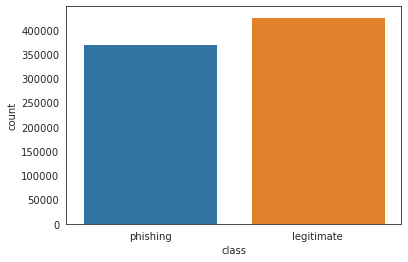

In [30]:
sns.countplot(data['class'])

In [31]:
data.describe()

,status,url_length,num_special_chars,num_digits,num_dots,num_slash,domain_length,num_digits_in_domain,pcount,ptld,spl,is_HTTPS,depth
count,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000,798463.000000
mean,0.534668,46.989770,1.575764,3.869836,2.107584,2.481535,9.697123,0.223239,2.107584,1.057397,3.107584,0.152658,2.388301
std,0.498797,41.677619,3.327733,10.649120,1.476300,1.837469,4.861222,1.055759,1.476300,0.234321,1.476300,0.359658,1.779572
min,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000
25%,0.000000,26.000000,0.000000,0.000000,1.000000,1.000000,7.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000
50%,1.000000,37.000000,0.000000,0.000000,2.000000,2.000000,9.000000,0.000000,2.000000,1.000000,3.000000,0.000000,2.000000
75%,1.000000,55.000000,2.000000,4.000000,2.000000,3.000000,12.000000,0.000000,2.000000,1.000000,3.000000,0.000000,3.000000
max,1.000000,3992.000000,261.000000,1575.000000,37.000000,51.000000,63.000000,40.000000,37.000000,3.000000,38.000000,1.000000,35.000000


In [32]:
data.top_domain.describe()

count     798463
unique      1232
top          com
freq      468951
Name: top_domain, dtype: object

In [33]:
data[data['status']==0].top_domain.describe()

count     371550
unique      1015
top          com
freq      155498
Name: top_domain, dtype: object

In [34]:
data[data['status']==1].top_domain.describe()

count     426913
unique       605
top          com
freq      313453
Name: top_domain, dtype: object

In [35]:
data[data['status']==0].top_domain.value_counts()[:10]

com       155498
cn         31429
org        21111
net        15228
top        11990
ru          6985
com.br      6215
xyz         5901
info        5448
shop        4804
Name: top_domain, dtype: int64

In [36]:
data[data['status']==1].top_domain.value_counts()[:10]

com       313453
org        46710
net        15729
edu        10840
ca          8786
co.uk       5423
gov         3330
de          1521
info        1430
com.au      1283
Name: top_domain, dtype: int64

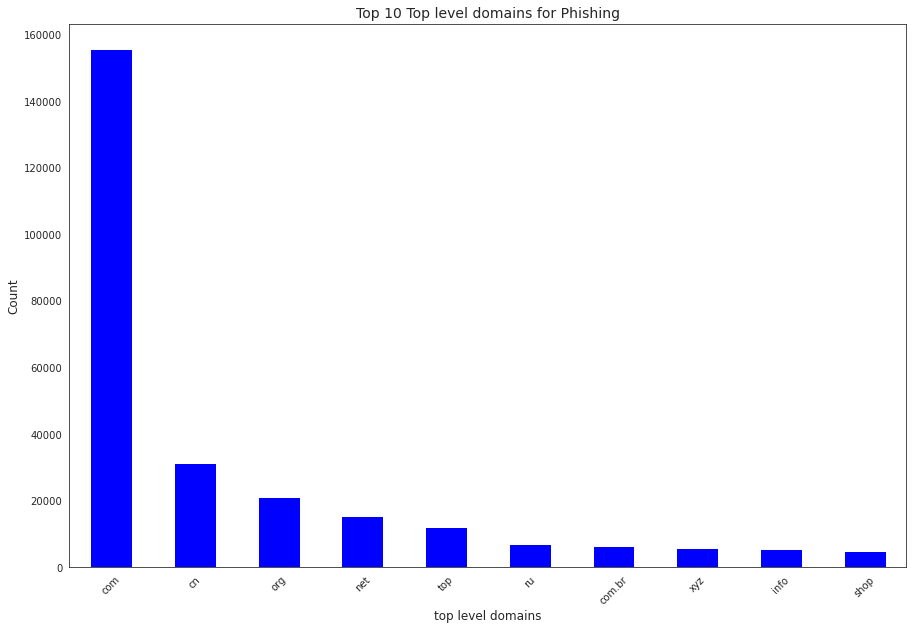

<Figure size 0x288 with 0 Axes>

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==0].top_domain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 Top level domains for Phishing',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()


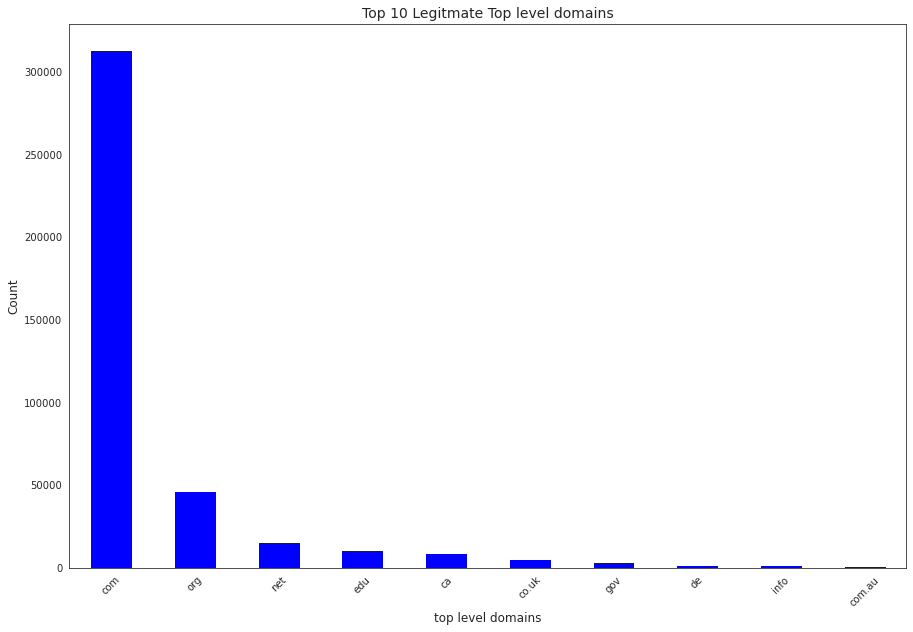

<Figure size 0x288 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==1].top_domain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 Legitmate Top level domains',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [39]:
data.domain

0          godaddysites
1          godaddysites
2                 00003
3          godaddysites
4              wcomhost
              ...      
822005            zzufg
822006              zzu
822007              zzz
822008       zzzoolight
822009    000webhostapp
Name: domain, Length: 798463, dtype: object

In [40]:
n=data[data['status']==1].domain.value_counts()[:10]
n

wikipedia    14766
youtube       9052
facebook      8629
blogspot      7689
yahoo         5878
amazon        5407
linkedin      5123
imdb          3631
ietf          3239
myspace       2934
Name: domain, dtype: int64

In [41]:
m=data[data['status']==0].domain.value_counts()[:10] 
m

duckdns          12853
000webhostapp     7571
blogspot          2092
workers           1675
googlegroups      1537
pastehtml          962
firebaseapp        762
google             743
appspot            656
rebrand            583
Name: domain, dtype: int64

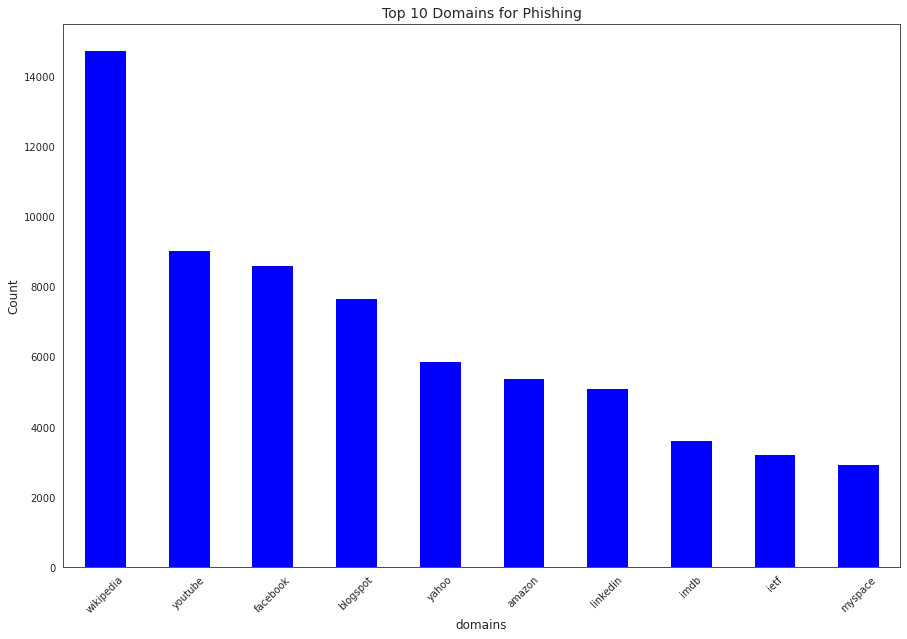

<Figure size 0x288 with 0 Axes>

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
n.plot.bar(color='blue', ax=ax)
plt.title('Top 10 Domains for Phishing',size=14)
plt.xlabel('domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

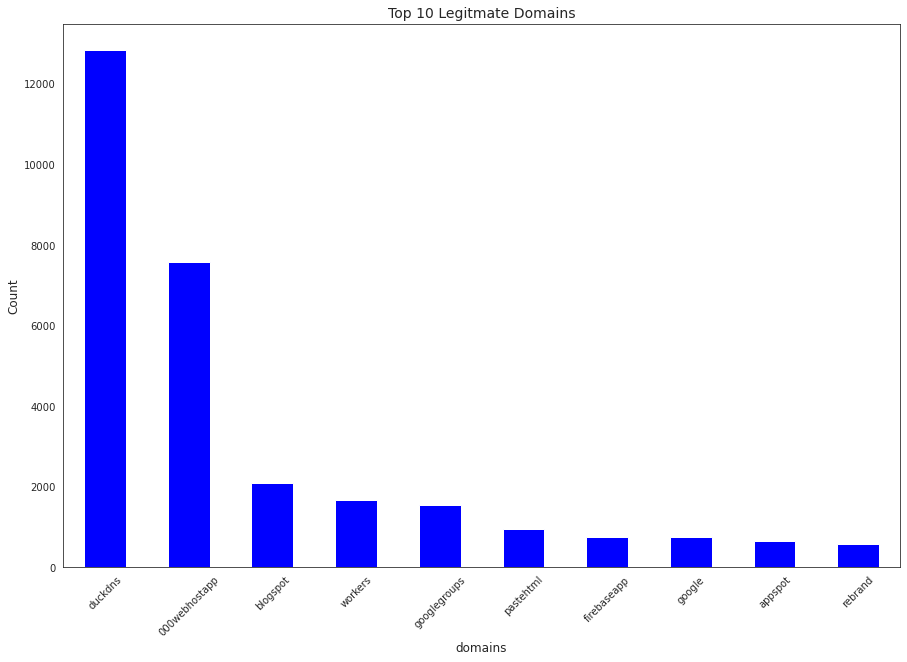

<Figure size 0x288 with 0 Axes>

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
m.plot.bar(color='blue', ax=ax)
plt.title('Top 10 Legitmate Domains',size=14)
plt.xlabel('domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

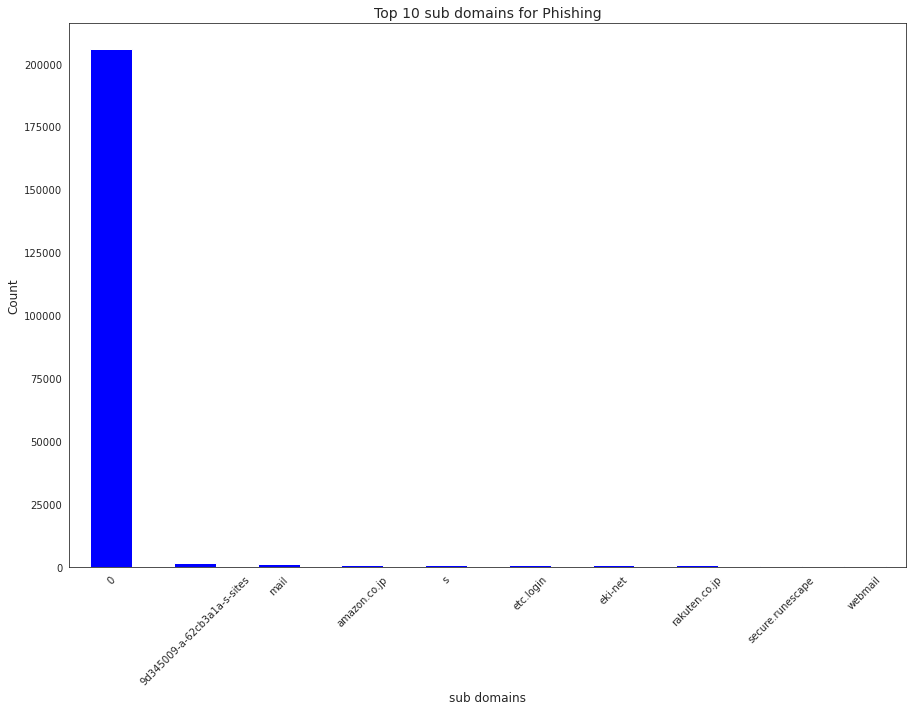

<Figure size 0x288 with 0 Axes>

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==0].subdomain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 sub domains for Phishing',size=14)
plt.xlabel('sub domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

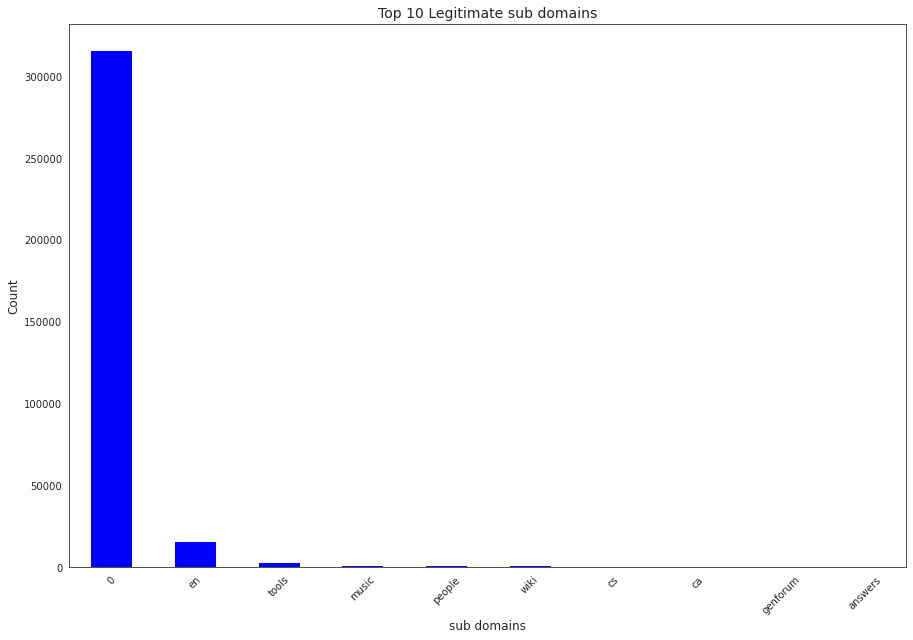

<Figure size 0x288 with 0 Axes>

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==1].subdomain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 Legitimate sub domains',size=14)
plt.xlabel('sub domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [46]:
data.is_HTTPS.sum()

121892

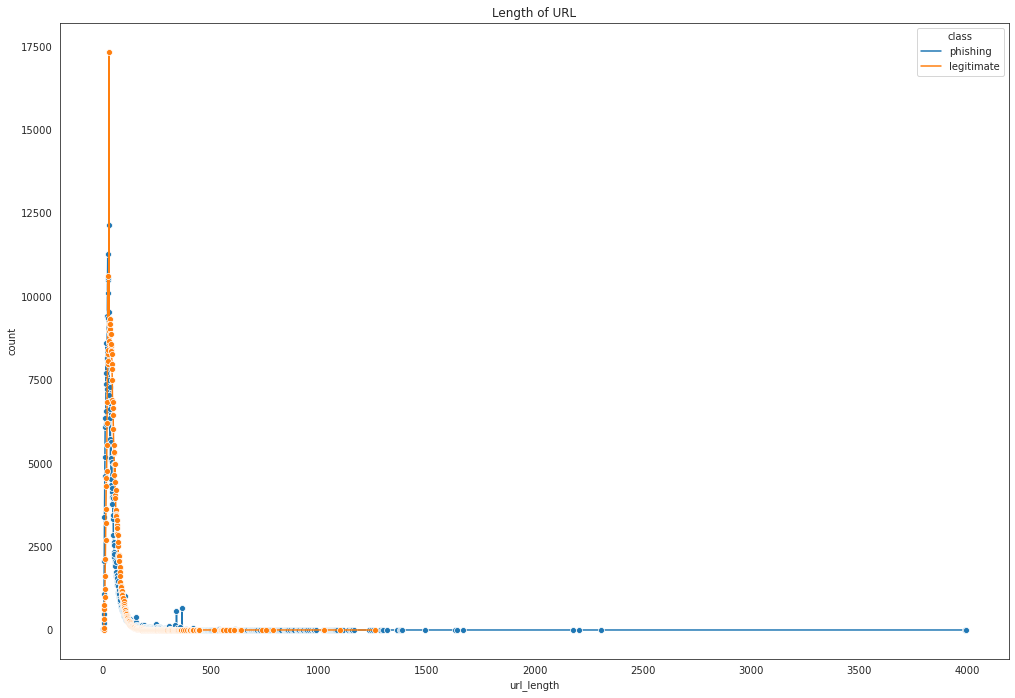

In [47]:
grouped_data = data.groupby(['url_length', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='url_length', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Length of URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

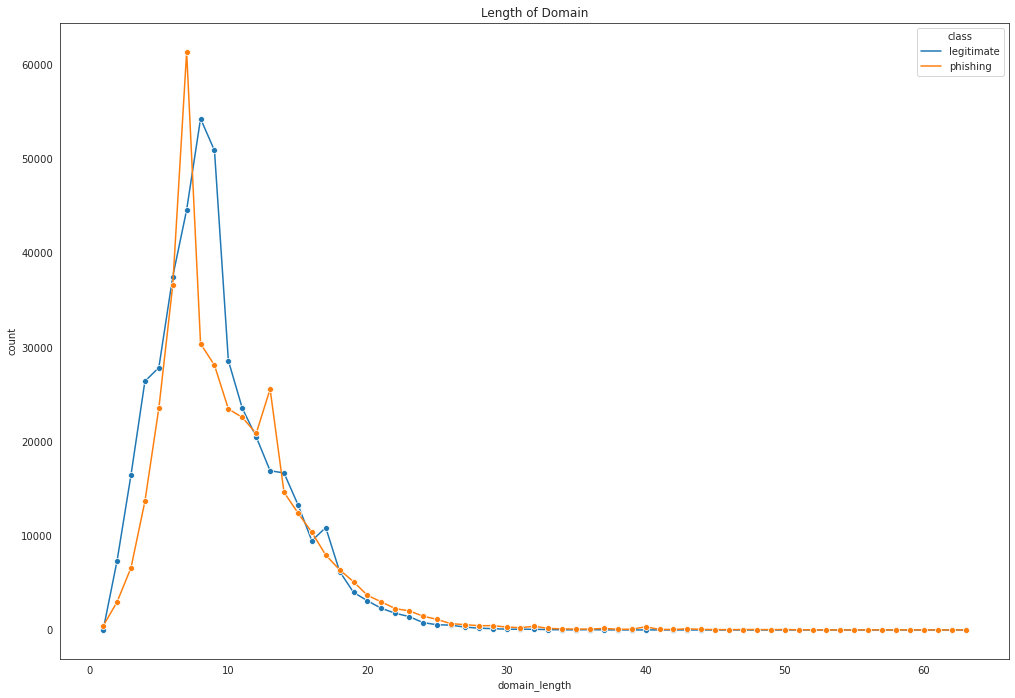

In [48]:
grouped_data = data.groupby(['domain_length', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='domain_length', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Length of Domain")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

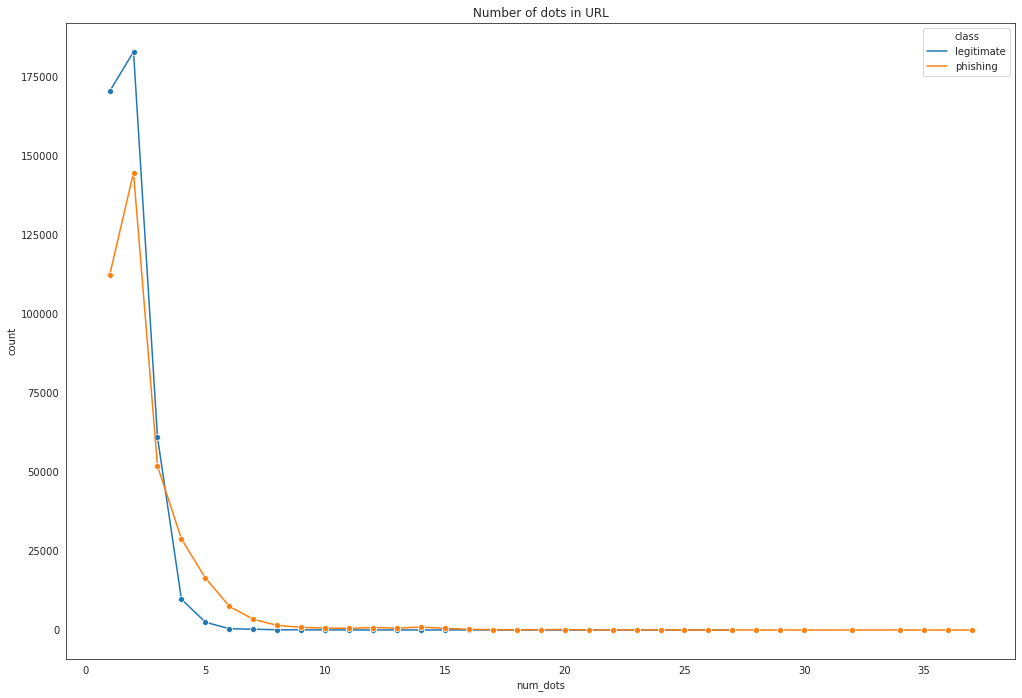

In [49]:
grouped_data = data.groupby(['num_dots', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_dots', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

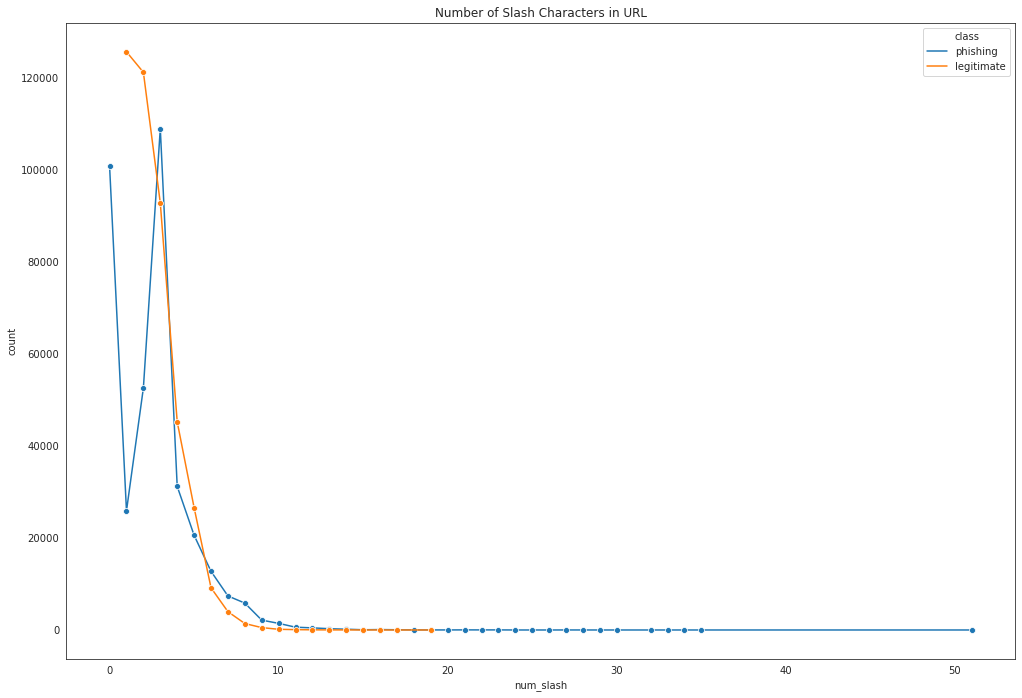

In [50]:
grouped_data = data.groupby(['num_slash', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_slash', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Slash Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

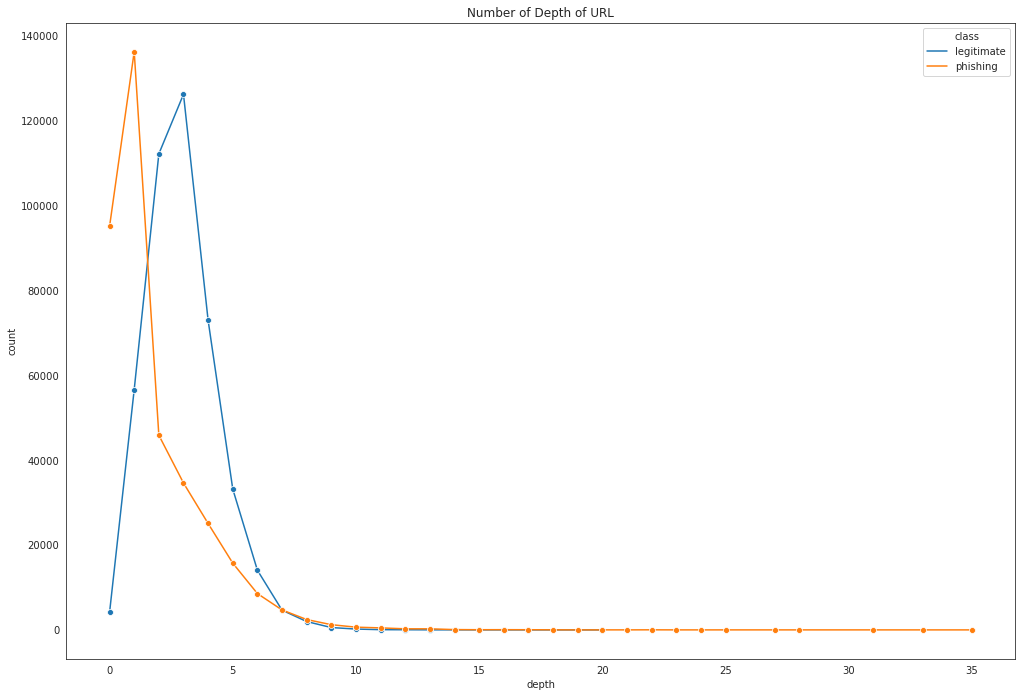

In [51]:
grouped_data = data.groupby(['depth', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='depth', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Depth of URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [52]:
data
def sub_dig(sub):
    if sub:
        return sum(c.isdigit() for c in sub)
    return 0
data['subdomain_digits']=data['subdomain'].apply(sub_dig)

In [53]:
data

,url,status,url_length,class,num_special_chars,num_digits,num_dots,num_slash,domain,domain_length,num_digits_in_domain,subdomain,pcount,top_domain,ptld,spl,is_HTTPS,depth,subdomain_digits
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,7,2,0,godaddysites,12,0,0000111servicehelpdesk,2,com,1,3,0,1,7
1,000011accesswebform.godaddysites.com,0,36,phishing,0,6,2,0,godaddysites,12,0,000011accesswebform,2,com,1,3,0,1,6
2,00003.online,0,12,phishing,0,5,1,0,00003,5,5,0,1,online,1,2,0,1,0
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,4,2,0,godaddysites,12,0,0009servicedeskowa,2,com,1,3,0,1,4
4,000n38p.wcomhost.com,0,20,phishing,0,5,2,0,wcomhost,8,0,000n38p,2,com,1,3,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822005,zzufg.com,0,9,phishing,0,0,1,0,zzufg,5,0,0,1,com,1,2,0,1,0
822006,zzu.li,0,6,phishing,0,0,1,0,zzu,3,0,0,1,li,1,2,0,1,0
822007,zzz.co.uk,0,9,phishing,0,0,2,0,zzz,3,0,0,2,co.uk,2,3,0,1,0
822008,zzzoolight.co.za,0,16,phishing,0,0,2,0,zzzoolight,10,0,0,2,co.za,2,3,0,1,0


In [54]:
data.to_csv('cleaned_data.csv',index=False)